# 5. Voice classification

## 5.1 데이터를 불러오고 확인해본다

In [1]:
# 프로제트를 진행하기에 앞서, 데이터를 다운받아야하고, 그 데이터를 담을 폴더를 생성해 줘야한다.
# $ mkdir -p ~/aiffel/speech_recognition/data
# $ mkdir -p ~/aiffel/speech_recognition/models
# $ wget https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz -P ~/aiffel/speech_recognition/data
import numpy as np
import os
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [2]:
# 다운 받은 데이터셋를 한 번 확인해보자
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [3]:
# 소리를 들어보자
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보자)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  8355
Wave data shape :  (8000,)
label :  ['no']


## 5.2 데이터를 전처리 및 변환하고 Train/Test 셋을 적절하게 나눠준다

In [4]:
# 현재 단어의 정답을 Text형태로 이루어져있다. 떄문에, Text 데이터를 학습 가능한 형태로 만들어줘야 한다.
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [5]:
# 위와 같이 Labeling 해줬다면, index 형태로 바꿔주는 작업을 해야한다.
temp = []
for v in speech_data["label_vals"][:30000]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([3, 3, 3, ..., 7, 7, 7])

In [6]:
# wav 데이터를 Spectrogram 데이터로 변환하기 위해 아래와 같은 몇 가지 작업이 필요하다
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [7]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


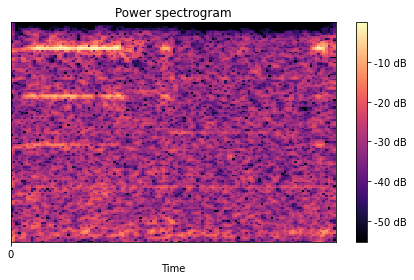

In [9]:
import librosa.display
import matplotlib.pyplot as plt


librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [10]:
# 데이터를 변환해서 spec이라는 변수에 담는다
spec = []
spec_temp = []

for w in speech_data["wav_vals"][:30000]:
    spec_temp.append(wav2spec(w))
    
spec = np.array(spec_temp)
print(spec.shape)

'''
spec = list(map(wav2spec, speech_data['wav_vals']))
spec = np.array(spec)
spec.shape
'''

(30000, 130, 126)


"\nspec = list(map(wav2spec, speech_data['wav_vals']))\nspec = np.array(spec)\nspec.shape\n"

In [11]:
# 학습을 위해서 데이터를 분리 해줘야한다.
from sklearn.model_selection import train_test_split

train_wav, test_wav, train_label, test_label = train_test_split(spec, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)

In [12]:
# 나눠진 데이터셋을 확인해 보자
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (27000, 130, 126)
train labels :  (27000,)
test data :  (3000, 130, 126)
test labels :  (3000,)


In [13]:
# 학습을 위한 파라미터를 설정해주겠다. 그리고 모델 체크포인트 저장을 위한 체크포인트의 경로를 설정해준다.
# 이것은 나중에 모델 체크포인트 Callback  함수를 설정하거나, 모델을 불러올때 사용한다.
batch_size = 256
max_epochs = 15

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/ssac3/aiffel/speech_recognition/models/wav'

### Data setting

tf.data.Dataset을 이용해서 데이터셋을 구성할 것이다. Tensorflow에 포함된 이 데이터셋 관리 패키지는 데이터셋 전처리, 배치처리 등을 쉽게 할 수 있도록 해준다.
tf.data.Dataset.from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용할 수 있다.
map 함수는 dataset이 데이터를 불러올때마다 동작시킬 데이터 전처리 함수를 매핑해 주는 역할을 한다. 첫번째 map 함수는 from_tensor_slice 에 입력한 튜플 형태로 데이터를 받으며 return 값으로 어떤 데이터를 반환할지 결정한다.
map 함수는 중첩해서 사용이 가능하다.
아래와 같이, map 함수에 넘겨줄 데이터 전처리 함수를 작성해 보겠다.

In [14]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [15]:
# tf.data.Dataset 함수를 구성해본다. 여기서 batch는 dataset에서 제공하는 튜플형태의 데이터를 얼마나 가져올지 결정하는 함수다.
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


## 5.3 Wave classification 모델 구현

In [16]:
# Conv1D layer를 이용해서 모델을 만들어보겠다
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

modelSpec = tf.keras.Model(input_tensor, output_tensor)

modelSpec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0     

In [17]:
# 12개의 단어 class를 가지고 있으므로 해당 class를 구분하기 위해서는 multi-class classification이 필요하다.
# 이를 수행하기 위해서 Loss로 Categorical Cross-Entropy loss을 사용한다.
optimizer=tf.keras.optimizers.Adam(1e-4)
modelSpec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [18]:
# model.fit  함수를 이용할 때, callback 함수를 이용해서 학습 중간 중간 원하는 동작을 하도록 설정이 가능하다.
# 모델을 재사용하기 위해서 모델 가중치를 저장하는 callback 함수를 추가해보겠다.
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [19]:
# 30분 내외가 소요된다...
history_wav = modelSpec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/15
105/105 [==============================] - ETA: 0s - loss: 1.9128 - accuracy: 0.3495
Epoch 00001: val_loss improved from inf to 2.35047, saving model to /home/ssac3/aiffel/speech_recognition/models/wav
105/105 [==============================] - 4s 40ms/step - loss: 1.9128 - accuracy: 0.3495 - val_loss: 2.3505 - val_accuracy: 0.5000
Epoch 2/15
105/105 [==============================] - ETA: 0s - loss: 1.2473 - accuracy: 0.5717
Epoch 00002: val_loss improved from 2.35047 to 2.04918, saving model to /home/ssac3/aiffel/speech_recognition/models/wav
105/105 [==============================] - 4s 37ms/step - loss: 1.2473 - accuracy: 0.5717 - val_loss: 2.0492 - val_accuracy: 0.6367
Epoch 3/15
105/105 [==============================] - ETA: 0s - loss: 0.9266 - accuracy: 0.6790
Epoch 00003: val_loss improved from 2.04918 to 1.56351, saving model to /home/ssac3/aiffel/speech_recognition/models/wav
105/105 [==============================] - 4s 37ms/step - loss: 0.9266 - accuracy: 0.6790

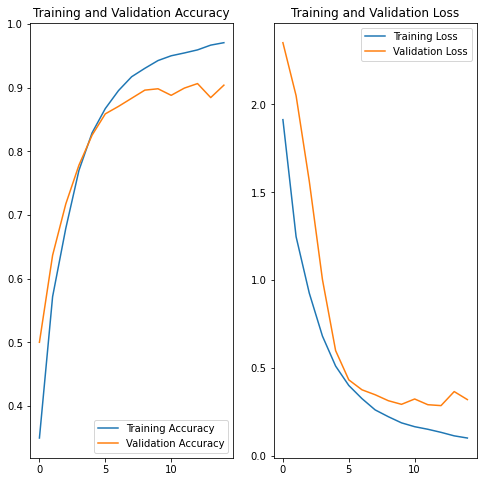

✅


In [20]:
# model.fit 함수는 학습 동안의 결과를 return해준다. 그 return 값을 기반으로 loss와 accuracy를 그래프로 표현해 볼 것이다.
# train loss와 val_loss의 차이가 커지는 경우 오버피팅이 일어나는 것이기 때문에 이를 수정할 필요가 있다.
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [21]:
# checkpoint callback 함수가 저정한 weight를 다시 불러와서 테스트 준비를 해본다
modelSpec.load_weights(checkpoint_dir)
print("✅")

✅


In [22]:
# Test data을 이용하여 모델의 예측값과 실제값이 얼마나 일치하는지 확인해본다
results = modelSpec.evaluate(test_dataset)
print("✅")

12/12 [==============================] - 1s 66ms/step - loss: 0.2888 - accuracy: 0.9057
✅


In [23]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.289
accuracy value: 90.5667%
✅


In [32]:
# Test data 셋을 골라서 직접 들어보고 모델의 에측이 맞는지 확인해 보자
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = modelSpec(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(16380,), rate=9000)

label :  left


In [33]:
# 위에서 확인해본 테스트셋의 라벨과 우리 모델의 실제 prediction 결과를 비교해본다
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: left(Correct!)
✅


## 5.2 Skip-Connection model을 구현해본다

In [34]:
# 모델 구현
input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

modelSpec_skip = tf.keras.Model(input_tensor, output_tensor)

modelSpec_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 130, 32)      36320       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 130, 32)      9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 65, 32)       0           conv1d_11[0][0]                  
____________________________________________________________________________________________

In [35]:
# 모델 훈련
optimizer=tf.keras.optimizers.Adam(1e-4)
modelSpec_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [36]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [37]:
# 30분 내외 소요
history_wav_skip = modelSpec_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/15
105/105 [==============================] - ETA: 0s - loss: 2.0818 - accuracy: 0.3009
Epoch 00001: val_loss improved from inf to 1.75917, saving model to /home/ssac3/aiffel/speech_recognition/models/wav_skip
105/105 [==============================] - 4s 41ms/step - loss: 2.0818 - accuracy: 0.3009 - val_loss: 1.7592 - val_accuracy: 0.4890
Epoch 2/15
105/105 [==============================] - ETA: 0s - loss: 1.3865 - accuracy: 0.5304
Epoch 00002: val_loss improved from 1.75917 to 1.31583, saving model to /home/ssac3/aiffel/speech_recognition/models/wav_skip
105/105 [==============================] - 4s 40ms/step - loss: 1.3865 - accuracy: 0.5304 - val_loss: 1.3158 - val_accuracy: 0.5728
Epoch 3/15
105/105 [==============================] - ETA: 0s - loss: 1.0492 - accuracy: 0.6382
Epoch 00003: val_loss improved from 1.31583 to 1.00330, saving model to /home/ssac3/aiffel/speech_recognition/models/wav_skip
105/105 [==============================] - 4s 41ms/step - loss: 1.0492 - a

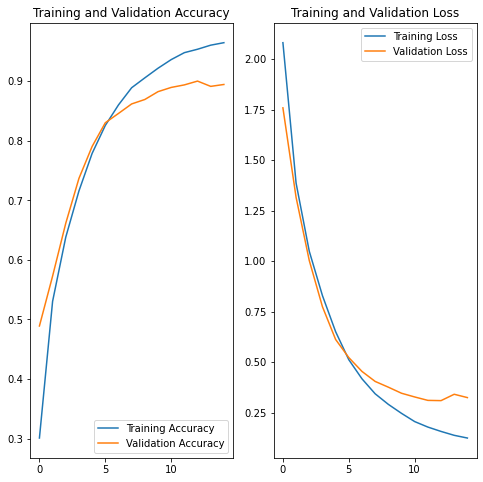

✅


In [38]:
# 학습결과 시각화
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [39]:
# Evaluation 

modelSpec_skip.load_weights(checkpoint_dir)
results = modelSpec_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

12/12 [==============================] - 0s 20ms/step - loss: 0.3141 - accuracy: 0.8990
loss value: 0.314
accuracy value: 89.9000%
✅


In [45]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = modelSpec_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(16380,), rate=8000)

label :  down


In [46]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: down(Correct!)
✅


## 회고
이번 프로젝트에서는 자연어처리의 일종인 음성인식을 진행하였다. 지금까지 진행한 프로젝트와는 달리 개념이 워낙에 난해하고 수식들도 많이 나와서 복습을 철저히 해야겠다는 생각이 든다. 처음에 데이터셋 전체를 사용하여 학습을 진행하려고 했는데 컴퓨터의 성능이 안좋아서?? 커널이 계속해서 죽는 문제가 발생하였다. 구글에 검색을 했는데 배치사이즈를 줄여봐라 모델을 가볍게 해라 이런 말이 있어서 배치 사이즈를 줄여봤지만 여전히 문제는 해결되지 않았다. 그래서 데이터셋의 개수를 줄여서 학습을 시켰더니 무난히 학습되었다. 루브릭에 있는 평가기준대로 모두 충족했으니 완벽하게 프로젝트를 끝냈다고 판단할수는 있겠으나...스펙토그램으로 바꿔서 모델을 학습 한 후에 평가를 할때 ipd.Audio함수를 써서 정답과 실제 음성이 맞는지를 확인해봐야하는데 이 부분은 이상한 잡음만 나오고 실제 어떤 말인지 구분을 할 수가 없었다. 물론....다시 wav데이터로 바꿔서 들어보는 방법이 있겠지만...그냥 넘어가려고 한다...